# Facial Expression Recognition

## Initialisation

In [ ]:
!pip install fastai
from fastai.vision.all import *
from fastai.vision.widgets import *

# Define paths
working_dir = "/kaggle/working/"
data_source = Path("/kaggle/input/fer2013")
data_dir = os.path.join(working_dir, 'data')

# Copying Data - we must use a writeable directory to clean the data
if not os.path.exists(data_dir):
    shutil.copytree(data_source, data_dir)
else:
    print(f"Directory {data_dir} already exists. Skipping copying.")


## Prepare labels

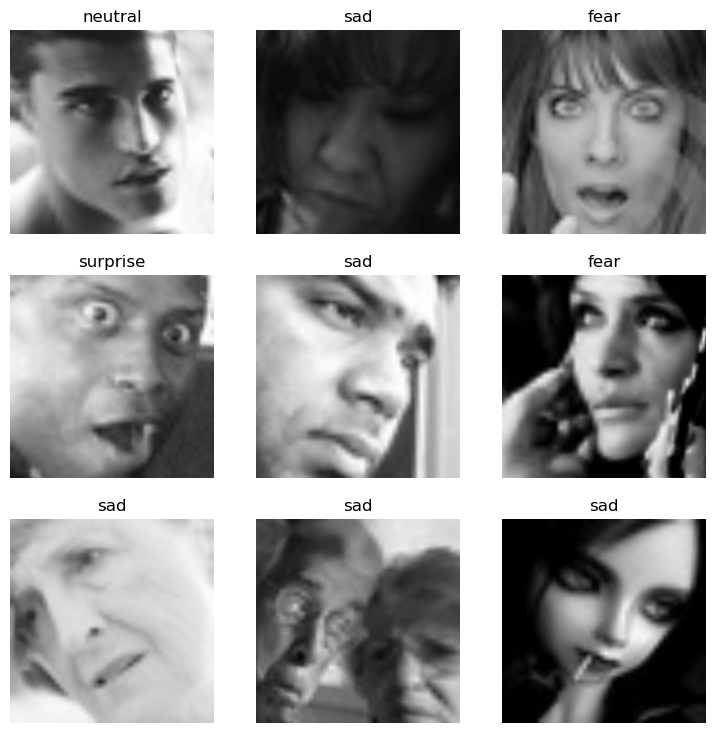

In [3]:
faces = ImageDataLoaders.from_folder(data_dir, train="train", valid_pct=0.2, item_tfms=Resize(224), batch_tfms=aug_transforms(size=224))

faces.show_batch()

## Create and test a learner

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 50.2MB/s]


SuggestedLRs(valley=0.0030199517495930195)

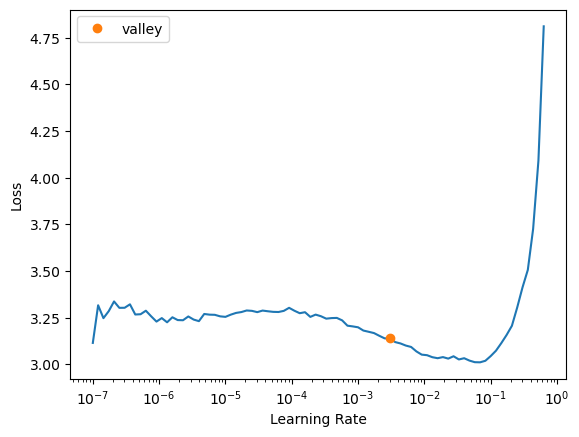

In [4]:
# create a learner
learn = vision_learner(faces, resnet34, metrics=error_rate, model_dir=os.path.join(working_dir, 'models'))
learn.lr_find() # find the optimal learning rate

epoch,train_loss,valid_loss,error_rate,time
0,1.680521,1.500333,0.569597,01:45


epoch,train_loss,valid_loss,error_rate,time
0,1.152929,1.040261,0.393061,01:59
1,0.938828,0.905586,0.338303,02:00


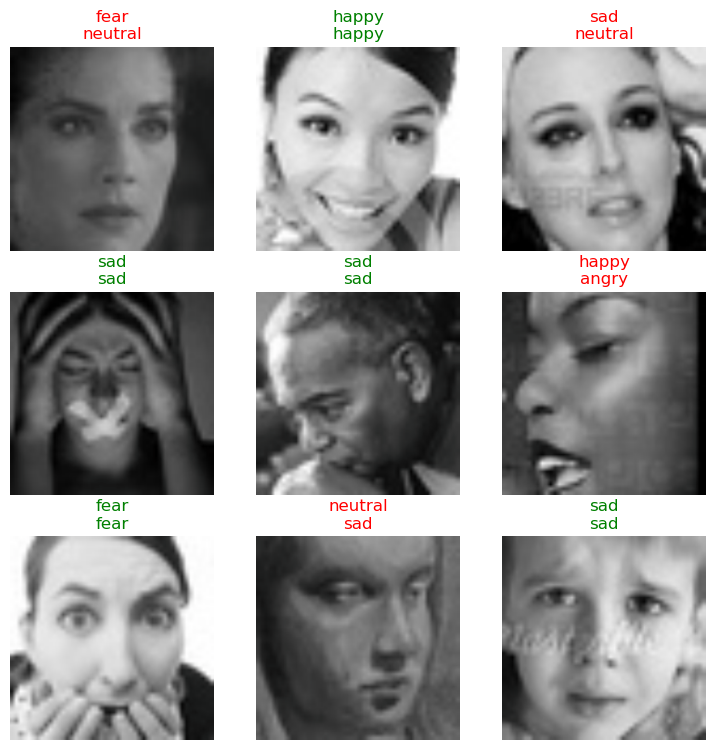

In [5]:
learn.fine_tune(2, 3e-3) # train the model
learn.show_results() # check the results

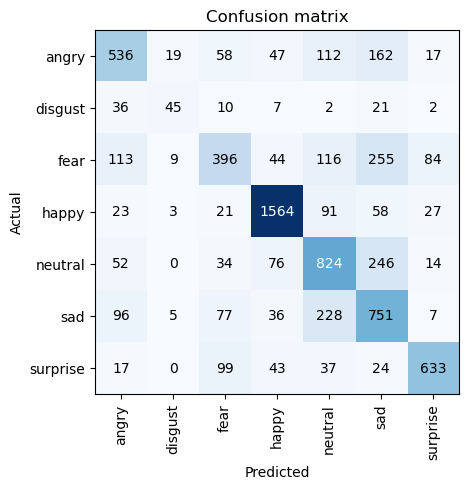

In [6]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

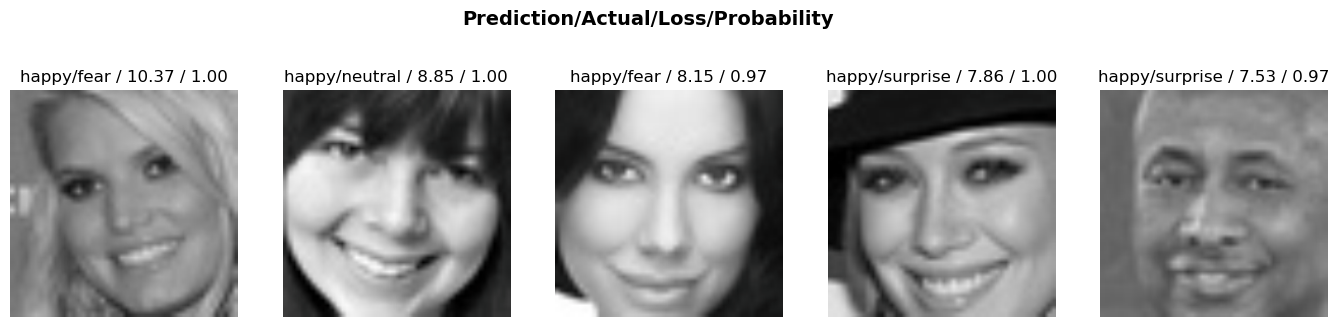

In [7]:
interp.plot_top_losses(5, nrows=1, figsize=(17,4))

These predictions are actually correct, so it looks like we'll need to do some data cleaning.

In [7]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [13]:
# Deleting Unwanted Images
for idx in cleaner.delete():
    if cleaner.fns[idx].exists(): cleaner.fns[idx].unlink()

# Moving (or Re-categorizing) Images
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), data_dir + '/' + cat)

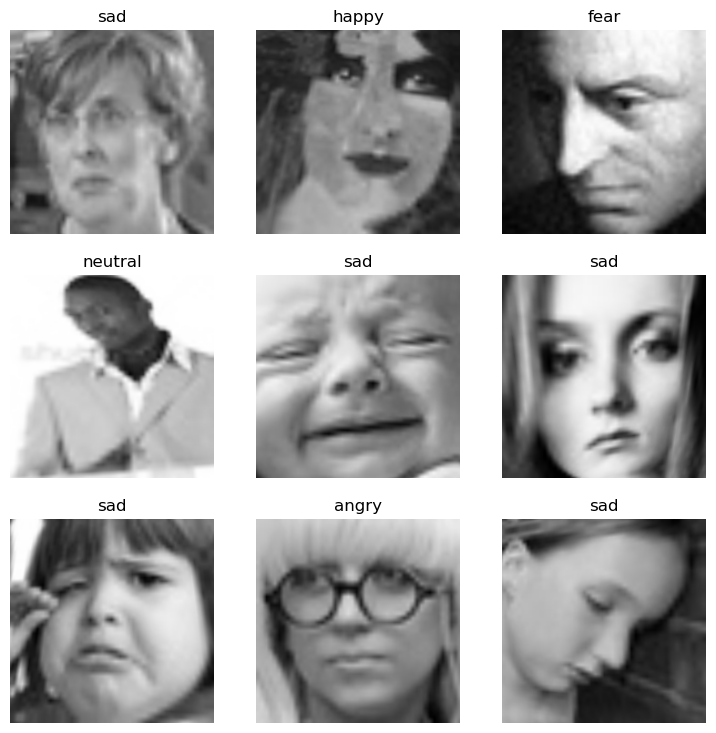

In [14]:
faces = ImageDataLoaders.from_folder(data_dir, train="train", valid_pct=0.2, item_tfms=Resize(224), batch_tfms=aug_transforms(size=224))

faces.show_batch()


SuggestedLRs(valley=0.0030199517495930195)

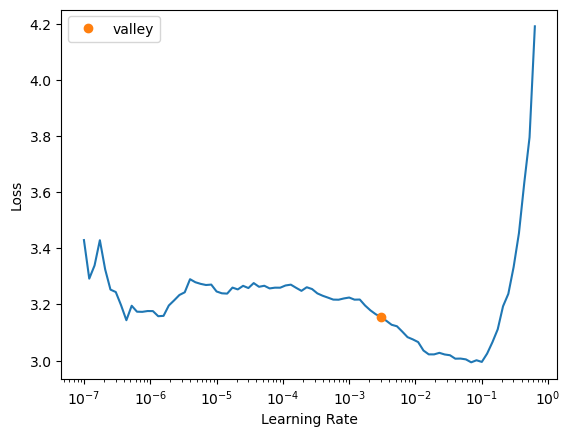

In [21]:
# create a learner
learn_clean = vision_learner(faces, resnet34, metrics=error_rate, model_dir=os.path.join(working_dir, 'models'))
learn_clean.lr_find() # find the optimal learning rate

epoch,train_loss,valid_loss,error_rate,time
0,1.939023,1.566035,0.577282,01:43


epoch,train_loss,valid_loss,error_rate,time
0,1.400734,1.235327,0.463554,01:59
1,1.167557,1.047499,0.390941,01:59
2,1.015952,0.954661,0.350662,01:59
3,0.913328,0.921014,0.339512,01:58
4,0.812671,0.899749,0.333659,01:59
5,0.771632,0.897657,0.326132,01:59


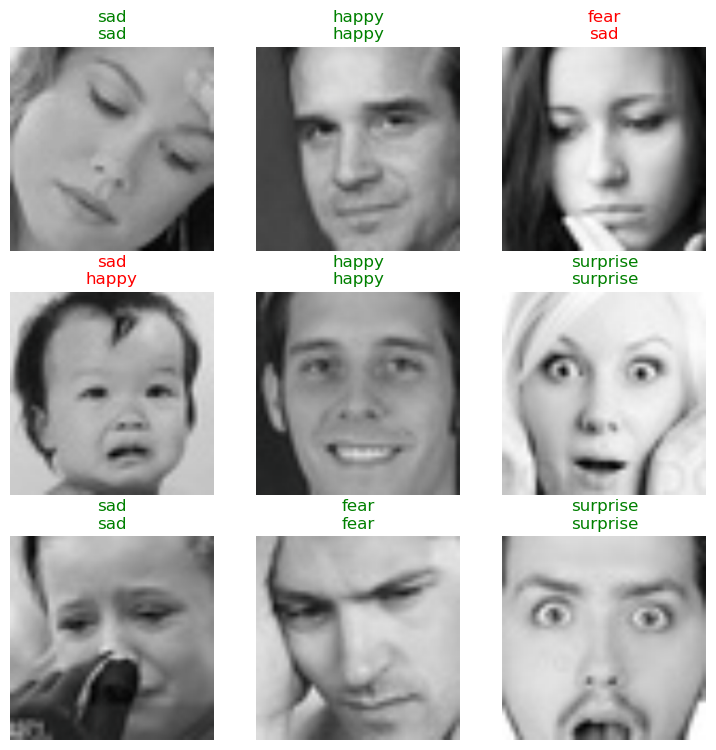

In [22]:
learn_clean.fine_tune(6, 1e-3) # train the model
learn_clean.show_results() # check the results

## Testing the fine-tuned model

After running all cells above, try to upload a file and test the model

In [25]:
!pip install ipywidgets

from ipywidgets import FileUpload
from IPython.display import display, Image

In [26]:
upload = FileUpload()
display(upload)

FileUpload(value={}, description='Upload')

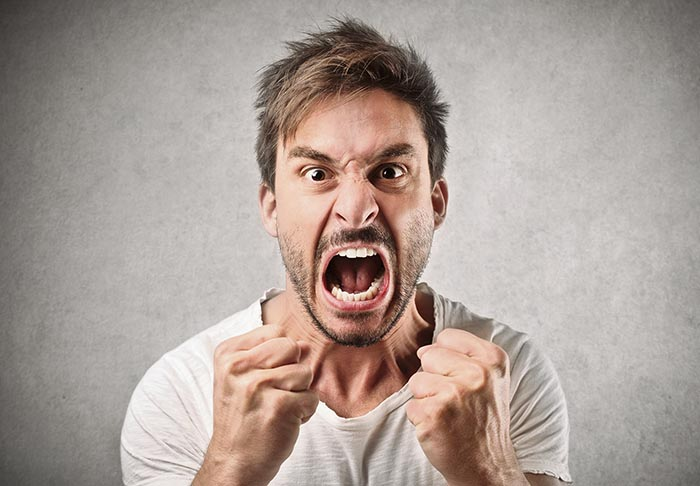

In [38]:
# Get the uploaded file (this gets the first and only file)
uploaded_file = list(upload.value.values())[0]

# Display the image
image = Image(uploaded_file['content'])
display(image)

In [44]:
from PIL import Image as PILImageClass
from io import BytesIO

uploaded_image_pil = PILImageClass.open(BytesIO(uploaded_file['content']))

In [45]:
prediction = learn_clean.predict(uploaded_image_pil)
print(prediction)

AttributeError: 'NoneType' object has no attribute 'crop'

In [46]:
learn_clean.export('/kaggle/working/model.pkl')